In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer

In [2]:
def make_train_test(data, test_size=0.3):
    sbd = data[data['sbj'] == 1]
    X_train, X_test, y1, y2 = train_test_split(sbd, sbd, test_size=test_size)
    for i in range(2, data.sbj.max()+1):
        sbd = data[data['sbj'] == i]
        tr, ts, y1, y2 = train_test_split(sbd, sbd, test_size=test_size)
        X_train = pd.concat([X_train, tr])
        X_test = pd.concat([X_test, ts])
        
    return X_train.reset_index(drop=True), X_test.reset_index(drop=True)

In [3]:
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[1]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [4]:
df1 = pd.read_csv('../../_data/Sepulveda_et_al_2020-master/data/value/GlamDataFF2018_Dislike_NoBin.csv', index_col=0)
df2 = pd.read_csv('../../_data/Sepulveda_et_al_2020-master/data/value/GlamDataFF2018_Like_NoBin.csv', index_col=0)
df1['goal'] = -1
df2['goal'] = 1
data_df = pd.concat([df1, df2]).sort_values(by=['subject', 'trial'])
data_df.reset_index(drop=True, inplace=True)

data_df['rt'] /= 1000

data_df.rename(columns={'subject': 'sbj'}, inplace=True)
data_df['sbj'] = data_df['sbj'].map({data_df['sbj'].unique()[i]:i+1 for i in range(len(data_df['sbj'].unique()))})

mean_rt = data_df.groupby('sbj')['rt'].mean()
std_rt = data_df.groupby('sbj')['rt'].std()
RT_Max = mean_rt + 3 * std_rt

rt_max = []
for i in range(data_df.shape[0]):
    rt_max.append(RT_Max[data_df['sbj'][i]])
data_df['rt_max'] = rt_max
data_df = data_df[(data_df['rt']>0.25) & (data_df['rt']<data_df['rt_max'])].reset_index(drop=True)

data_df.reset_index(drop=True, inplace=True)

data_df['Right Value - Left Value'] = data_df['item_value_1'] - data_df['item_value_0']

data_df['gaze diff'] = data_df['gaze_1'] - data_df['gaze_0']
kbins = KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='uniform')
data_df['gaze diff'] = kbins.fit_transform(data_df[['gaze diff']])
mms = MinMaxScaler(feature_range=(-1, 1))
data_df['Dwell Time Advantage (R - L)'] = mms.fit_transform(data_df[['gaze diff']])

min_rt = data_df.groupby(by='sbj')['rt'].min()

In [5]:
tr_df, ts_df = make_train_test(data_df, test_size=0.3)

obs_train = np.asarray(tr_df[['rt', 'choice']])
X_train = np.asarray(tr_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1', 'goal']])

obs_test = np.asarray(ts_df[['rt', 'choice']])
X_test = np.asarray(ts_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1', 'goal']])

print(X_train.shape, X_test.shape)

(5090, 5) (2199, 5)


In [6]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):
    ndt = tf.convert_to_tensor([min_rt[i]*tf.math.sigmoid(model.layers[-1].weights[-1][i-1]) for i in tr_df['sbj']])
    thr = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-2][i-1])) for i in tr_df['sbj']])
    scl = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-3][i-1])) for i in tr_df['sbj']])
    
    ll1 = (1 - obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]))
    
    return -2*tf.reduce_sum(tf.math.log(ll1 + ll2), axis=-1)

In [7]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [8]:
layers_neuron = [10, 10, 10, 8]
input_shape = 5
output_shape = 2
activation = 'tanh'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                60        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 8)                 88        
                                                                 
 out_layer (Out_layer)       (None, 2)                 111       
                                                                 
Total params: 479 (1.87 KB)
Trainable params: 479 (1.87 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [9]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=3000)

Epoch 1/3000
1/1 [==============================] - 150s 150s/step - loss: 42622.3828
Epoch 2/3000
1/1 [==============================] - 0s 72ms/step - loss: 42367.0469
Epoch 3/3000
1/1 [==============================] - 0s 56ms/step - loss: 42182.4141
Epoch 4/3000
1/1 [==============================] - 0s 45ms/step - loss: 42025.5312
Epoch 5/3000
1/1 [==============================] - 0s 44ms/step - loss: 41883.8633
Epoch 6/3000
1/1 [==============================] - 0s 49ms/step - loss: 41752.0469
Epoch 7/3000
1/1 [==============================] - 0s 45ms/step - loss: 41627.2617
Epoch 8/3000
1/1 [==============================] - 0s 43ms/step - loss: 41507.8633
Epoch 9/3000
1/1 [==============================] - 0s 43ms/step - loss: 41392.7891
Epoch 10/3000
1/1 [==============================] - 0s 40ms/step - loss: 41281.3359
Epoch 11/3000
1/1 [==============================] - 0s 37ms/step - loss: 41172.9883
Epoch 12/3000
1/1 [==============================] - 0s 38ms/step - loss

1/1 [==============================] - 0s 52ms/step - loss: 35560.8281
Epoch 98/3000
1/1 [==============================] - 0s 49ms/step - loss: 35521.5078
Epoch 99/3000
1/1 [==============================] - 0s 49ms/step - loss: 35482.5781
Epoch 100/3000
1/1 [==============================] - 0s 52ms/step - loss: 35444.0312
Epoch 101/3000
1/1 [==============================] - 0s 51ms/step - loss: 35405.8516
Epoch 102/3000
1/1 [==============================] - 0s 51ms/step - loss: 35368.0391
Epoch 103/3000
1/1 [==============================] - 0s 49ms/step - loss: 35330.5938
Epoch 104/3000
1/1 [==============================] - 0s 50ms/step - loss: 35293.5000
Epoch 105/3000
1/1 [==============================] - 0s 49ms/step - loss: 35256.7539
Epoch 106/3000
1/1 [==============================] - 0s 51ms/step - loss: 35220.3516
Epoch 107/3000
1/1 [==============================] - 0s 52ms/step - loss: 35184.2891
Epoch 108/3000
1/1 [==============================] - 0s 52ms/step - lo

1/1 [==============================] - 0s 68ms/step - loss: 32945.9141
Epoch 193/3000
1/1 [==============================] - 0s 60ms/step - loss: 32926.0820
Epoch 194/3000
1/1 [==============================] - 0s 57ms/step - loss: 32906.3555
Epoch 195/3000
1/1 [==============================] - 0s 59ms/step - loss: 32886.7266
Epoch 196/3000
1/1 [==============================] - 0s 57ms/step - loss: 32867.1953
Epoch 197/3000
1/1 [==============================] - 0s 62ms/step - loss: 32847.7578
Epoch 198/3000
1/1 [==============================] - 0s 57ms/step - loss: 32828.4219
Epoch 199/3000
1/1 [==============================] - 0s 61ms/step - loss: 32809.1797
Epoch 200/3000
1/1 [==============================] - 0s 57ms/step - loss: 32790.0234
Epoch 201/3000
1/1 [==============================] - 0s 56ms/step - loss: 32770.9648
Epoch 202/3000
1/1 [==============================] - 0s 56ms/step - loss: 32751.9941
Epoch 203/3000
1/1 [==============================] - 0s 54ms/step - 

1/1 [==============================] - 0s 48ms/step - loss: 31384.7109
Epoch 288/3000
1/1 [==============================] - 0s 50ms/step - loss: 31370.7402
Epoch 289/3000
1/1 [==============================] - 0s 50ms/step - loss: 31356.8125
Epoch 290/3000
1/1 [==============================] - 0s 49ms/step - loss: 31342.9180
Epoch 291/3000
1/1 [==============================] - 0s 49ms/step - loss: 31329.0566
Epoch 292/3000
1/1 [==============================] - 0s 50ms/step - loss: 31315.2305
Epoch 293/3000
1/1 [==============================] - 0s 49ms/step - loss: 31301.4375
Epoch 294/3000
1/1 [==============================] - 0s 50ms/step - loss: 31287.6855
Epoch 295/3000
1/1 [==============================] - 0s 49ms/step - loss: 31273.9648
Epoch 296/3000
1/1 [==============================] - 0s 51ms/step - loss: 31260.2773
Epoch 297/3000
1/1 [==============================] - 0s 50ms/step - loss: 31246.6191
Epoch 298/3000
1/1 [==============================] - 0s 52ms/step - 

1/1 [==============================] - 0s 55ms/step - loss: 30184.4941
Epoch 383/3000
1/1 [==============================] - 0s 55ms/step - loss: 30172.9375
Epoch 384/3000
1/1 [==============================] - 0s 55ms/step - loss: 30161.4043
Epoch 385/3000
1/1 [==============================] - 0s 54ms/step - loss: 30149.8867
Epoch 386/3000
1/1 [==============================] - 0s 55ms/step - loss: 30138.3867
Epoch 387/3000
1/1 [==============================] - 0s 55ms/step - loss: 30126.9062
Epoch 388/3000
1/1 [==============================] - 0s 53ms/step - loss: 30115.4395
Epoch 389/3000
1/1 [==============================] - 0s 54ms/step - loss: 30103.9941
Epoch 390/3000
1/1 [==============================] - 0s 54ms/step - loss: 30092.5645
Epoch 391/3000
1/1 [==============================] - 0s 54ms/step - loss: 30081.1543
Epoch 392/3000
1/1 [==============================] - 0s 52ms/step - loss: 30069.7617
Epoch 393/3000
1/1 [==============================] - 0s 52ms/step - 

1/1 [==============================] - 0s 49ms/step - loss: 29157.8906
Epoch 478/3000
1/1 [==============================] - 0s 49ms/step - loss: 29147.7617
Epoch 479/3000
1/1 [==============================] - 0s 49ms/step - loss: 29137.6543
Epoch 480/3000
1/1 [==============================] - 0s 51ms/step - loss: 29127.5605
Epoch 481/3000
1/1 [==============================] - 0s 50ms/step - loss: 29117.4727
Epoch 482/3000
1/1 [==============================] - 0s 48ms/step - loss: 29107.3984
Epoch 483/3000
1/1 [==============================] - 0s 51ms/step - loss: 29097.3398
Epoch 484/3000
1/1 [==============================] - 0s 52ms/step - loss: 29087.2930
Epoch 485/3000
1/1 [==============================] - 0s 50ms/step - loss: 29077.2520
Epoch 486/3000
1/1 [==============================] - 0s 51ms/step - loss: 29067.2344
Epoch 487/3000
1/1 [==============================] - 0s 52ms/step - loss: 29057.2227
Epoch 488/3000
1/1 [==============================] - 0s 50ms/step - 

1/1 [==============================] - 0s 51ms/step - loss: 28208.3047
Epoch 573/3000
1/1 [==============================] - 0s 53ms/step - loss: 28198.3789
Epoch 574/3000
1/1 [==============================] - 0s 50ms/step - loss: 28188.1895
Epoch 575/3000
1/1 [==============================] - 0s 52ms/step - loss: 28178.2480
Epoch 576/3000
1/1 [==============================] - 0s 50ms/step - loss: 28168.0469
Epoch 577/3000
1/1 [==============================] - 0s 49ms/step - loss: 28158.0703
Epoch 578/3000
1/1 [==============================] - 0s 51ms/step - loss: 28147.8535
Epoch 579/3000
1/1 [==============================] - 0s 51ms/step - loss: 28137.8457
Epoch 580/3000
1/1 [==============================] - 0s 51ms/step - loss: 28127.6133
Epoch 581/3000
1/1 [==============================] - 0s 57ms/step - loss: 28117.5566
Epoch 582/3000
1/1 [==============================] - 0s 54ms/step - loss: 28107.3105
Epoch 583/3000
1/1 [==============================] - 0s 54ms/step - 

1/1 [==============================] - 0s 50ms/step - loss: 27160.1074
Epoch 668/3000
1/1 [==============================] - 0s 51ms/step - loss: 27149.9922
Epoch 669/3000
1/1 [==============================] - 0s 49ms/step - loss: 27139.9414
Epoch 670/3000
1/1 [==============================] - 0s 49ms/step - loss: 27129.8633
Epoch 671/3000
1/1 [==============================] - 0s 49ms/step - loss: 27119.8555
Epoch 672/3000
1/1 [==============================] - 0s 51ms/step - loss: 27109.8086
Epoch 673/3000
1/1 [==============================] - 0s 50ms/step - loss: 27099.8320
Epoch 674/3000
1/1 [==============================] - 0s 49ms/step - loss: 27089.8223
Epoch 675/3000
1/1 [==============================] - 0s 48ms/step - loss: 27079.8906
Epoch 676/3000
1/1 [==============================] - 0s 50ms/step - loss: 27069.9375
Epoch 677/3000
1/1 [==============================] - 0s 50ms/step - loss: 27060.0645
Epoch 678/3000
1/1 [==============================] - 0s 50ms/step - 

1/1 [==============================] - 0s 49ms/step - loss: 26303.0352
Epoch 763/3000
1/1 [==============================] - 0s 49ms/step - loss: 26295.0508
Epoch 764/3000
1/1 [==============================] - 0s 52ms/step - loss: 26286.9062
Epoch 765/3000
1/1 [==============================] - 0s 50ms/step - loss: 26278.9531
Epoch 766/3000
1/1 [==============================] - 0s 49ms/step - loss: 26270.8438
Epoch 767/3000
1/1 [==============================] - 0s 49ms/step - loss: 26262.9219
Epoch 768/3000
1/1 [==============================] - 0s 51ms/step - loss: 26254.8398
Epoch 769/3000
1/1 [==============================] - 0s 50ms/step - loss: 26246.9492
Epoch 770/3000
1/1 [==============================] - 0s 52ms/step - loss: 26238.8984
Epoch 771/3000
1/1 [==============================] - 0s 49ms/step - loss: 26231.0332
Epoch 772/3000
1/1 [==============================] - 0s 49ms/step - loss: 26223.0117
Epoch 773/3000
1/1 [==============================] - 0s 50ms/step - 

1/1 [==============================] - 0s 51ms/step - loss: 25594.2305
Epoch 858/3000
1/1 [==============================] - 0s 52ms/step - loss: 25587.2012
Epoch 859/3000
1/1 [==============================] - 0s 49ms/step - loss: 25580.2949
Epoch 860/3000
1/1 [==============================] - 0s 49ms/step - loss: 25573.2812
Epoch 861/3000
1/1 [==============================] - 0s 51ms/step - loss: 25566.3906
Epoch 862/3000
1/1 [==============================] - 0s 52ms/step - loss: 25559.3945
Epoch 863/3000
1/1 [==============================] - 0s 50ms/step - loss: 25552.5195
Epoch 864/3000
1/1 [==============================] - 0s 52ms/step - loss: 25545.5449
Epoch 865/3000
1/1 [==============================] - 0s 50ms/step - loss: 25538.6836
Epoch 866/3000
1/1 [==============================] - 0s 49ms/step - loss: 25531.7227
Epoch 867/3000
1/1 [==============================] - 0s 52ms/step - loss: 25524.8809
Epoch 868/3000
1/1 [==============================] - 0s 50ms/step - 

1/1 [==============================] - 0s 50ms/step - loss: 24962.2676
Epoch 953/3000
1/1 [==============================] - 0s 50ms/step - loss: 24955.8359
Epoch 954/3000
1/1 [==============================] - 0s 51ms/step - loss: 24949.3945
Epoch 955/3000
1/1 [==============================] - 0s 51ms/step - loss: 24942.9668
Epoch 956/3000
1/1 [==============================] - 0s 51ms/step - loss: 24936.5234
Epoch 957/3000
1/1 [==============================] - 0s 51ms/step - loss: 24930.1016
Epoch 958/3000
1/1 [==============================] - 0s 49ms/step - loss: 24923.6621
Epoch 959/3000
1/1 [==============================] - 0s 50ms/step - loss: 24917.2383
Epoch 960/3000
1/1 [==============================] - 0s 50ms/step - loss: 24910.8008
Epoch 961/3000
1/1 [==============================] - 0s 48ms/step - loss: 24904.3770
Epoch 962/3000
1/1 [==============================] - 0s 48ms/step - loss: 24897.9453
Epoch 963/3000
1/1 [==============================] - 0s 51ms/step - 

1/1 [==============================] - 0s 51ms/step - loss: 24345.7695
Epoch 1047/3000
1/1 [==============================] - 0s 49ms/step - loss: 24338.8555
Epoch 1048/3000
1/1 [==============================] - 0s 51ms/step - loss: 24331.9805
Epoch 1049/3000
1/1 [==============================] - 0s 50ms/step - loss: 24325.0449
Epoch 1050/3000
1/1 [==============================] - 0s 50ms/step - loss: 24318.1484
Epoch 1051/3000
1/1 [==============================] - 0s 49ms/step - loss: 24311.1855
Epoch 1052/3000
1/1 [==============================] - 0s 51ms/step - loss: 24304.2656
Epoch 1053/3000
1/1 [==============================] - 0s 50ms/step - loss: 24297.2812
Epoch 1054/3000
1/1 [==============================] - 0s 52ms/step - loss: 24290.3398
Epoch 1055/3000
1/1 [==============================] - 0s 51ms/step - loss: 24283.3262
Epoch 1056/3000
1/1 [==============================] - 0s 51ms/step - loss: 24276.3594
Epoch 1057/3000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 51ms/step - loss: 23641.3984
Epoch 1141/3000
1/1 [==============================] - 0s 52ms/step - loss: 23633.3047
Epoch 1142/3000
1/1 [==============================] - 0s 52ms/step - loss: 23625.3066
Epoch 1143/3000
1/1 [==============================] - 0s 53ms/step - loss: 23617.2012
Epoch 1144/3000
1/1 [==============================] - 0s 60ms/step - loss: 23609.1934
Epoch 1145/3000
1/1 [==============================] - 0s 59ms/step - loss: 23601.0820
Epoch 1146/3000
1/1 [==============================] - 0s 55ms/step - loss: 23593.0645
Epoch 1147/3000
1/1 [==============================] - 0s 58ms/step - loss: 23584.9414
Epoch 1148/3000
1/1 [==============================] - 0s 60ms/step - loss: 23576.9180
Epoch 1149/3000
1/1 [==============================] - 0s 59ms/step - loss: 23568.7930
Epoch 1150/3000
1/1 [==============================] - 0s 64ms/step - loss: 23560.7656
Epoch 1151/3000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 69ms/step - loss: 22923.1992
Epoch 1235/3000
1/1 [==============================] - 0s 64ms/step - loss: 22915.6484
Epoch 1236/3000
1/1 [==============================] - 0s 62ms/step - loss: 22908.1602
Epoch 1237/3000
1/1 [==============================] - 0s 55ms/step - loss: 22900.4238
Epoch 1238/3000
1/1 [==============================] - 0s 61ms/step - loss: 22892.7305
Epoch 1239/3000
1/1 [==============================] - 0s 57ms/step - loss: 22884.7617
Epoch 1240/3000
1/1 [==============================] - 0s 55ms/step - loss: 22876.8203
Epoch 1241/3000
1/1 [==============================] - 0s 52ms/step - loss: 22868.5742
Epoch 1242/3000
1/1 [==============================] - 0s 52ms/step - loss: 22860.3359
Epoch 1243/3000
1/1 [==============================] - 0s 51ms/step - loss: 22851.7715
Epoch 1244/3000
1/1 [==============================] - 0s 50ms/step - loss: 22843.1855
Epoch 1245/3000
1/1 [==============================] - 0s 5

1/1 [==============================] - 0s 50ms/step - loss: 22106.6094
Epoch 1329/3000
1/1 [==============================] - 0s 51ms/step - loss: 22100.7305
Epoch 1330/3000
1/1 [==============================] - 0s 52ms/step - loss: 22094.9805
Epoch 1331/3000
1/1 [==============================] - 0s 50ms/step - loss: 22089.1230
Epoch 1332/3000
1/1 [==============================] - 0s 52ms/step - loss: 22083.3945
Epoch 1333/3000
1/1 [==============================] - 0s 50ms/step - loss: 22077.5645
Epoch 1334/3000
1/1 [==============================] - 0s 51ms/step - loss: 22071.8613
Epoch 1335/3000
1/1 [==============================] - 0s 53ms/step - loss: 22066.0605
Epoch 1336/3000
1/1 [==============================] - 0s 57ms/step - loss: 22060.3867
Epoch 1337/3000
1/1 [==============================] - 0s 54ms/step - loss: 22054.6133
Epoch 1338/3000
1/1 [==============================] - 0s 54ms/step - loss: 22048.9688
Epoch 1339/3000
1/1 [==============================] - 0s 5

1/1 [==============================] - 0s 49ms/step - loss: 21575.6797
Epoch 1423/3000
1/1 [==============================] - 0s 51ms/step - loss: 21569.7070
Epoch 1424/3000
1/1 [==============================] - 0s 52ms/step - loss: 21563.7930
Epoch 1425/3000
1/1 [==============================] - 0s 51ms/step - loss: 21557.7910
Epoch 1426/3000
1/1 [==============================] - 0s 52ms/step - loss: 21551.8555
Epoch 1427/3000
1/1 [==============================] - 0s 52ms/step - loss: 21545.8242
Epoch 1428/3000
1/1 [==============================] - 0s 49ms/step - loss: 21539.8652
Epoch 1429/3000
1/1 [==============================] - 0s 50ms/step - loss: 21533.8047
Epoch 1430/3000
1/1 [==============================] - 0s 51ms/step - loss: 21527.8164
Epoch 1431/3000
1/1 [==============================] - 0s 52ms/step - loss: 21521.7266
Epoch 1432/3000
1/1 [==============================] - 0s 50ms/step - loss: 21515.7109
Epoch 1433/3000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 51ms/step - loss: 20931.3223
Epoch 1517/3000
1/1 [==============================] - 0s 51ms/step - loss: 20924.1172
Epoch 1518/3000
1/1 [==============================] - 0s 52ms/step - loss: 20917.1816
Epoch 1519/3000
1/1 [==============================] - 0s 50ms/step - loss: 20910.0430
Epoch 1520/3000
1/1 [==============================] - 0s 51ms/step - loss: 20903.1758
Epoch 1521/3000
1/1 [==============================] - 0s 51ms/step - loss: 20896.1055
Epoch 1522/3000
1/1 [==============================] - 0s 51ms/step - loss: 20889.3008
Epoch 1523/3000
1/1 [==============================] - 0s 52ms/step - loss: 20882.2910
Epoch 1524/3000
1/1 [==============================] - 0s 49ms/step - loss: 20875.5469
Epoch 1525/3000
1/1 [==============================] - 0s 51ms/step - loss: 20868.5918
Epoch 1526/3000
1/1 [==============================] - 0s 50ms/step - loss: 20861.9219
Epoch 1527/3000
1/1 [==============================] - 0s 5

1/1 [==============================] - 0s 51ms/step - loss: 20394.9727
Epoch 1611/3000
1/1 [==============================] - 0s 48ms/step - loss: 20390.2109
Epoch 1612/3000
1/1 [==============================] - 0s 50ms/step - loss: 20385.9492
Epoch 1613/3000
1/1 [==============================] - 0s 53ms/step - loss: 20381.3203
Epoch 1614/3000
1/1 [==============================] - 0s 51ms/step - loss: 20377.1445
Epoch 1615/3000
1/1 [==============================] - 0s 50ms/step - loss: 20372.5215
Epoch 1616/3000
1/1 [==============================] - 0s 49ms/step - loss: 20368.2969
Epoch 1617/3000
1/1 [==============================] - 0s 50ms/step - loss: 20363.5938
Epoch 1618/3000
1/1 [==============================] - 0s 51ms/step - loss: 20359.3008
Epoch 1619/3000
1/1 [==============================] - 0s 49ms/step - loss: 20354.5938
Epoch 1620/3000
1/1 [==============================] - 0s 51ms/step - loss: 20350.3750
Epoch 1621/3000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 50ms/step - loss: 20043.5547
Epoch 1705/3000
1/1 [==============================] - 0s 51ms/step - loss: 20040.4766
Epoch 1706/3000
1/1 [==============================] - 0s 49ms/step - loss: 20037.9492
Epoch 1707/3000
1/1 [==============================] - 0s 49ms/step - loss: 20034.7285
Epoch 1708/3000
1/1 [==============================] - 0s 51ms/step - loss: 20032.0273
Epoch 1709/3000
1/1 [==============================] - 0s 50ms/step - loss: 20028.5859
Epoch 1710/3000
1/1 [==============================] - 0s 50ms/step - loss: 20025.7461
Epoch 1711/3000
1/1 [==============================] - 0s 50ms/step - loss: 20022.3398
Epoch 1712/3000
1/1 [==============================] - 0s 50ms/step - loss: 20019.5977
Epoch 1713/3000
1/1 [==============================] - 0s 50ms/step - loss: 20016.4082
Epoch 1714/3000
1/1 [==============================] - 0s 50ms/step - loss: 20013.8945
Epoch 1715/3000
1/1 [==============================] - 0s 5

1/1 [==============================] - 0s 50ms/step - loss: 19813.1367
Epoch 1799/3000
1/1 [==============================] - 0s 51ms/step - loss: 19810.7285
Epoch 1800/3000
1/1 [==============================] - 0s 50ms/step - loss: 19809.0742
Epoch 1801/3000
1/1 [==============================] - 0s 50ms/step - loss: 19807.1250
Epoch 1802/3000
1/1 [==============================] - 0s 49ms/step - loss: 19805.8359
Epoch 1803/3000
1/1 [==============================] - 0s 50ms/step - loss: 19803.9102
Epoch 1804/3000
1/1 [==============================] - 0s 50ms/step - loss: 19802.4473
Epoch 1805/3000
1/1 [==============================] - 0s 49ms/step - loss: 19800.0703
Epoch 1806/3000
1/1 [==============================] - 0s 52ms/step - loss: 19798.2422
Epoch 1807/3000
1/1 [==============================] - 0s 52ms/step - loss: 19795.7266
Epoch 1808/3000
1/1 [==============================] - 0s 49ms/step - loss: 19793.8789
Epoch 1809/3000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 50ms/step - loss: 19655.4062
Epoch 1893/3000
1/1 [==============================] - 0s 50ms/step - loss: 19654.0059
Epoch 1894/3000
1/1 [==============================] - 0s 50ms/step - loss: 19653.1387
Epoch 1895/3000
1/1 [==============================] - 0s 49ms/step - loss: 19651.5352
Epoch 1896/3000
1/1 [==============================] - 0s 49ms/step - loss: 19650.3340
Epoch 1897/3000
1/1 [==============================] - 0s 50ms/step - loss: 19648.3359
Epoch 1898/3000
1/1 [==============================] - 0s 49ms/step - loss: 19646.8438
Epoch 1899/3000
1/1 [==============================] - 0s 50ms/step - loss: 19644.8691
Epoch 1900/3000
1/1 [==============================] - 0s 51ms/step - loss: 19643.5449
Epoch 1901/3000
1/1 [==============================] - 0s 50ms/step - loss: 19641.9805
Epoch 1902/3000
1/1 [==============================] - 0s 52ms/step - loss: 19641.0957
Epoch 1903/3000
1/1 [==============================] - 0s 5

1/1 [==============================] - 0s 55ms/step - loss: 19529.7109
Epoch 1987/3000
1/1 [==============================] - 0s 53ms/step - loss: 19528.0117
Epoch 1988/3000
1/1 [==============================] - 0s 51ms/step - loss: 19526.9023
Epoch 1989/3000
1/1 [==============================] - 0s 54ms/step - loss: 19525.6387
Epoch 1990/3000
1/1 [==============================] - 0s 54ms/step - loss: 19525.0156
Epoch 1991/3000
1/1 [==============================] - 0s 50ms/step - loss: 19524.1484
Epoch 1992/3000
1/1 [==============================] - 0s 50ms/step - loss: 19523.4238
Epoch 1993/3000
1/1 [==============================] - 0s 51ms/step - loss: 19521.9355
Epoch 1994/3000
1/1 [==============================] - 0s 49ms/step - loss: 19520.4297
Epoch 1995/3000
1/1 [==============================] - 0s 51ms/step - loss: 19518.6133
Epoch 1996/3000
1/1 [==============================] - 0s 52ms/step - loss: 19517.3398
Epoch 1997/3000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 50ms/step - loss: 19426.3184
Epoch 2081/3000
1/1 [==============================] - 0s 53ms/step - loss: 19424.9414
Epoch 2082/3000
1/1 [==============================] - 0s 52ms/step - loss: 19423.5156
Epoch 2083/3000
1/1 [==============================] - 0s 52ms/step - loss: 19421.9062
Epoch 2084/3000
1/1 [==============================] - 0s 51ms/step - loss: 19420.7891
Epoch 2085/3000
1/1 [==============================] - 0s 50ms/step - loss: 19419.6875
Epoch 2086/3000
1/1 [==============================] - 0s 51ms/step - loss: 19419.1602
Epoch 2087/3000
1/1 [==============================] - 0s 50ms/step - loss: 19418.3945
Epoch 2088/3000
1/1 [==============================] - 0s 53ms/step - loss: 19417.9375
Epoch 2089/3000
1/1 [==============================] - 0s 50ms/step - loss: 19416.7500
Epoch 2090/3000
1/1 [==============================] - 0s 51ms/step - loss: 19415.7344
Epoch 2091/3000
1/1 [==============================] - 0s 5

1/1 [==============================] - 0s 61ms/step - loss: 19336.6934
Epoch 2175/3000
1/1 [==============================] - 0s 57ms/step - loss: 19336.0566
Epoch 2176/3000
1/1 [==============================] - 0s 58ms/step - loss: 19335.8594
Epoch 2177/3000
1/1 [==============================] - 0s 58ms/step - loss: 19335.1738
Epoch 2178/3000
1/1 [==============================] - 0s 60ms/step - loss: 19334.5859
Epoch 2179/3000
1/1 [==============================] - 0s 56ms/step - loss: 19333.2207
Epoch 2180/3000
1/1 [==============================] - 0s 57ms/step - loss: 19332.1133
Epoch 2181/3000
1/1 [==============================] - 0s 55ms/step - loss: 19330.6680
Epoch 2182/3000
1/1 [==============================] - 0s 54ms/step - loss: 19329.6758
Epoch 2183/3000
1/1 [==============================] - 0s 51ms/step - loss: 19328.6602
Epoch 2184/3000
1/1 [==============================] - 0s 52ms/step - loss: 19328.2734
Epoch 2185/3000
1/1 [==============================] - 0s 5

1/1 [==============================] - 0s 53ms/step - loss: 19262.1836
Epoch 2269/3000
1/1 [==============================] - 0s 54ms/step - loss: 19261.3770
Epoch 2270/3000
1/1 [==============================] - 0s 54ms/step - loss: 19260.5957
Epoch 2271/3000
1/1 [==============================] - 0s 52ms/step - loss: 19259.1680
Epoch 2272/3000
1/1 [==============================] - 0s 53ms/step - loss: 19258.1133
Epoch 2273/3000
1/1 [==============================] - 0s 52ms/step - loss: 19256.8945
Epoch 2274/3000
1/1 [==============================] - 0s 52ms/step - loss: 19256.1602
Epoch 2275/3000
1/1 [==============================] - 0s 52ms/step - loss: 19255.5000
Epoch 2276/3000
1/1 [==============================] - 0s 53ms/step - loss: 19255.4688
Epoch 2277/3000
1/1 [==============================] - 0s 54ms/step - loss: 19255.3320
Epoch 2278/3000
1/1 [==============================] - 0s 53ms/step - loss: 19255.3711
Epoch 2279/3000
1/1 [==============================] - 0s 5

1/1 [==============================] - 0s 80ms/step - loss: 19196.9824
Epoch 2363/3000
1/1 [==============================] - 0s 71ms/step - loss: 19196.5078
Epoch 2364/3000
1/1 [==============================] - 0s 70ms/step - loss: 19195.9590
Epoch 2365/3000
1/1 [==============================] - 0s 73ms/step - loss: 19194.5508
Epoch 2366/3000
1/1 [==============================] - 0s 67ms/step - loss: 19193.3945
Epoch 2367/3000
1/1 [==============================] - 0s 68ms/step - loss: 19192.0469
Epoch 2368/3000
1/1 [==============================] - 0s 72ms/step - loss: 19191.3750
Epoch 2369/3000
1/1 [==============================] - 0s 62ms/step - loss: 19190.7148
Epoch 2370/3000
1/1 [==============================] - 0s 60ms/step - loss: 19190.7070
Epoch 2371/3000
1/1 [==============================] - 0s 62ms/step - loss: 19190.6602
Epoch 2372/3000
1/1 [==============================] - 0s 74ms/step - loss: 19190.9492
Epoch 2373/3000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 52ms/step - loss: 19138.9199
Epoch 2457/3000
1/1 [==============================] - 0s 55ms/step - loss: 19138.8652
Epoch 2458/3000
1/1 [==============================] - 0s 59ms/step - loss: 19139.4297
Epoch 2459/3000
1/1 [==============================] - 0s 53ms/step - loss: 19139.5039
Epoch 2460/3000
1/1 [==============================] - 0s 55ms/step - loss: 19139.4551
Epoch 2461/3000
1/1 [==============================] - 0s 61ms/step - loss: 19138.1758
Epoch 2462/3000
1/1 [==============================] - 0s 58ms/step - loss: 19137.0840
Epoch 2463/3000
1/1 [==============================] - 0s 64ms/step - loss: 19135.5781
Epoch 2464/3000
1/1 [==============================] - 0s 65ms/step - loss: 19134.6660
Epoch 2465/3000
1/1 [==============================] - 0s 62ms/step - loss: 19133.8125
Epoch 2466/3000
1/1 [==============================] - 0s 64ms/step - loss: 19133.7070
Epoch 2467/3000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 62ms/step - loss: 19091.4688
Epoch 2551/3000
1/1 [==============================] - 0s 60ms/step - loss: 19090.1484
Epoch 2552/3000
1/1 [==============================] - 0s 55ms/step - loss: 19089.3281
Epoch 2553/3000
1/1 [==============================] - 0s 55ms/step - loss: 19088.6172
Epoch 2554/3000
1/1 [==============================] - 0s 53ms/step - loss: 19088.5449
Epoch 2555/3000
1/1 [==============================] - 0s 58ms/step - loss: 19088.6094
Epoch 2556/3000
1/1 [==============================] - 0s 58ms/step - loss: 19089.6445
Epoch 2557/3000
1/1 [==============================] - 0s 56ms/step - loss: 19089.8672
Epoch 2558/3000
1/1 [==============================] - 0s 53ms/step - loss: 19089.5840
Epoch 2559/3000
1/1 [==============================] - 0s 57ms/step - loss: 19088.0508
Epoch 2560/3000
1/1 [==============================] - 0s 57ms/step - loss: 19086.5918
Epoch 2561/3000
1/1 [==============================] - 0s 5

1/1 [==============================] - 0s 52ms/step - loss: 19048.7188
Epoch 2645/3000
1/1 [==============================] - 0s 53ms/step - loss: 19049.0391
Epoch 2646/3000
1/1 [==============================] - 0s 56ms/step - loss: 19049.2949
Epoch 2647/3000
1/1 [==============================] - 0s 53ms/step - loss: 19048.5586
Epoch 2648/3000
1/1 [==============================] - 0s 55ms/step - loss: 19047.6211
Epoch 2649/3000
1/1 [==============================] - 0s 55ms/step - loss: 19046.1484
Epoch 2650/3000
1/1 [==============================] - 0s 52ms/step - loss: 19045.2695
Epoch 2651/3000
1/1 [==============================] - 0s 53ms/step - loss: 19044.3574
Epoch 2652/3000
1/1 [==============================] - 0s 56ms/step - loss: 19044.1309
Epoch 2653/3000
1/1 [==============================] - 0s 51ms/step - loss: 19044.1406
Epoch 2654/3000
1/1 [==============================] - 0s 55ms/step - loss: 19045.0352
Epoch 2655/3000
1/1 [==============================] - 0s 5

1/1 [==============================] - 0s 53ms/step - loss: 19009.8613
Epoch 2739/3000
1/1 [==============================] - 0s 53ms/step - loss: 19008.7969
Epoch 2740/3000
1/1 [==============================] - 0s 53ms/step - loss: 19008.7168
Epoch 2741/3000
1/1 [==============================] - 0s 52ms/step - loss: 19008.9609
Epoch 2742/3000
1/1 [==============================] - 0s 53ms/step - loss: 19009.4102
Epoch 2743/3000
1/1 [==============================] - 0s 52ms/step - loss: 19009.6094
Epoch 2744/3000
1/1 [==============================] - 0s 53ms/step - loss: 19009.8984
Epoch 2745/3000
1/1 [==============================] - 0s 55ms/step - loss: 19009.2500
Epoch 2746/3000
1/1 [==============================] - 0s 54ms/step - loss: 19008.5078
Epoch 2747/3000
1/1 [==============================] - 0s 52ms/step - loss: 19007.2090
Epoch 2748/3000
1/1 [==============================] - 0s 50ms/step - loss: 19006.3887
Epoch 2749/3000
1/1 [==============================] - 0s 5

1/1 [==============================] - 0s 51ms/step - loss: 18980.7109
Epoch 2833/3000
1/1 [==============================] - 0s 50ms/step - loss: 18979.6914
Epoch 2834/3000
1/1 [==============================] - 0s 50ms/step - loss: 18977.8477
Epoch 2835/3000
1/1 [==============================] - 0s 50ms/step - loss: 18975.7695
Epoch 2836/3000
1/1 [==============================] - 0s 51ms/step - loss: 18975.0195
Epoch 2837/3000
1/1 [==============================] - 0s 51ms/step - loss: 18974.3184
Epoch 2838/3000
1/1 [==============================] - 0s 52ms/step - loss: 18974.5312
Epoch 2839/3000
1/1 [==============================] - 0s 50ms/step - loss: 18974.6816
Epoch 2840/3000
1/1 [==============================] - 0s 50ms/step - loss: 18975.3711
Epoch 2841/3000
1/1 [==============================] - 0s 49ms/step - loss: 18975.1797
Epoch 2842/3000
1/1 [==============================] - 0s 115ms/step - loss: 18975.2070
Epoch 2843/3000
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 59ms/step - loss: 18946.3477
Epoch 2927/3000
1/1 [==============================] - 0s 52ms/step - loss: 18946.3848
Epoch 2928/3000
1/1 [==============================] - 0s 52ms/step - loss: 18947.1602
Epoch 2929/3000
1/1 [==============================] - 0s 54ms/step - loss: 18948.5273
Epoch 2930/3000
1/1 [==============================] - 0s 56ms/step - loss: 18950.4219
Epoch 2931/3000
1/1 [==============================] - 0s 56ms/step - loss: 18949.8887
Epoch 2932/3000
1/1 [==============================] - 0s 61ms/step - loss: 18947.9102
Epoch 2933/3000
1/1 [==============================] - 0s 60ms/step - loss: 18945.3887
Epoch 2934/3000
1/1 [==============================] - 0s 56ms/step - loss: 18944.2324
Epoch 2935/3000
1/1 [==============================] - 0s 54ms/step - loss: 18943.2070
Epoch 2936/3000
1/1 [==============================] - 0s 53ms/step - loss: 18943.4922
Epoch 2937/3000
1/1 [==============================] - 0s 5

In [10]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

69/69 [==============================] - 0s 328us/step


In [11]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'goal':[],
            'val1': [],
            'val2':[],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]-1], ndt[ts_df.sbj[s]-1])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['goal'].append(ts_df.goal[s])
        pred_bhv['val1'].append(ts_df.item_value_0[s])
        pred_bhv['val2'].append(ts_df.item_value_1[s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)
pred_bhv['diff'] = pred_bhv['val2'] - pred_bhv['val1']

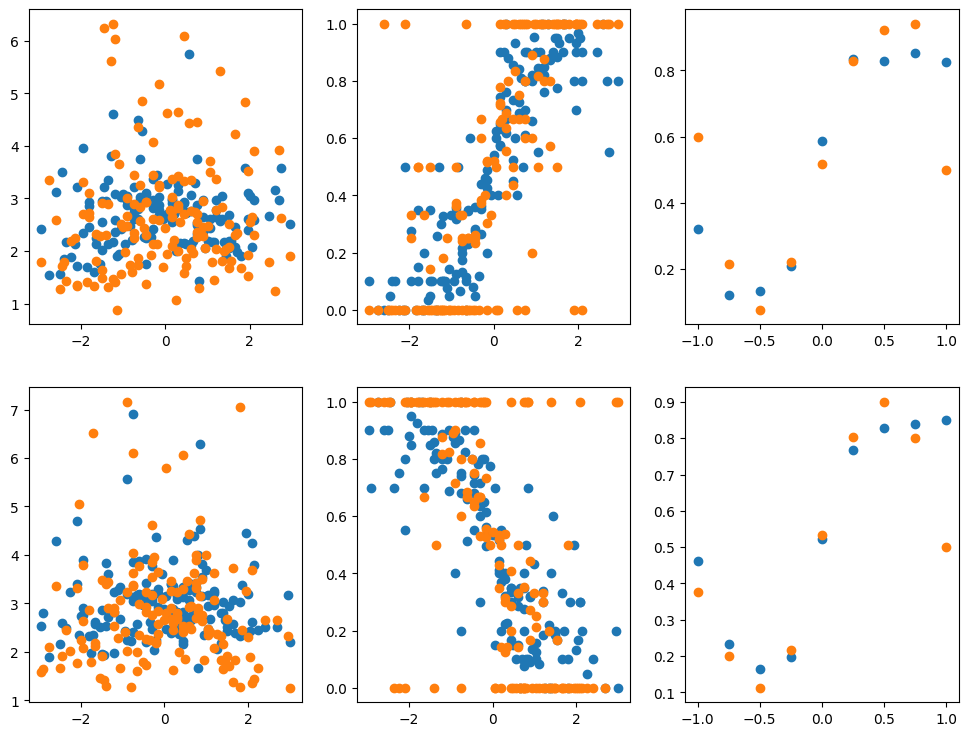

In [12]:
plt.figure(figsize=(12, 9))
plt.subplot(231)
plt.scatter(x=pred_bhv[pred_bhv['goal']==1].groupby(by='diff')['diff'].mean(), 
            y=pred_bhv[pred_bhv['goal']==1].groupby(by='diff')['rt'].mean());
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['rt'].mean());

plt.subplot(232)
plt.scatter(x=pred_bhv[pred_bhv['goal']==1].groupby(by='diff')['diff'].mean(), 
            y=pred_bhv[pred_bhv['goal']==1].groupby(by='diff')['ch'].mean());
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['choice'].mean());

plt.subplot(233)
plt.scatter(x=pred_bhv[pred_bhv['goal']==1].groupby(by='gaze_diff')['gaze_diff'].mean(), 
            y=pred_bhv[pred_bhv['goal']==1].groupby(by='gaze_diff')['ch'].mean());
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Dwell Time Advantage (R - L)')['choice'].mean());

###########
plt.subplot(234)
plt.scatter(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='diff')['diff'].mean(), 
            y=pred_bhv[pred_bhv['goal']==-1].groupby(by='diff')['rt'].mean());
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['rt'].mean());

plt.subplot(235)
plt.scatter(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='diff')['diff'].mean(), 
            y=pred_bhv[pred_bhv['goal']==-1].groupby(by='diff')['ch'].mean());
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['choice'].mean());

plt.subplot(236)
plt.scatter(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='gaze_diff')['gaze_diff'].mean(), 
            y=pred_bhv[pred_bhv['goal']==-1].groupby(by='gaze_diff')['ch'].mean());
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Dwell Time Advantage (R - L)')['choice'].mean());

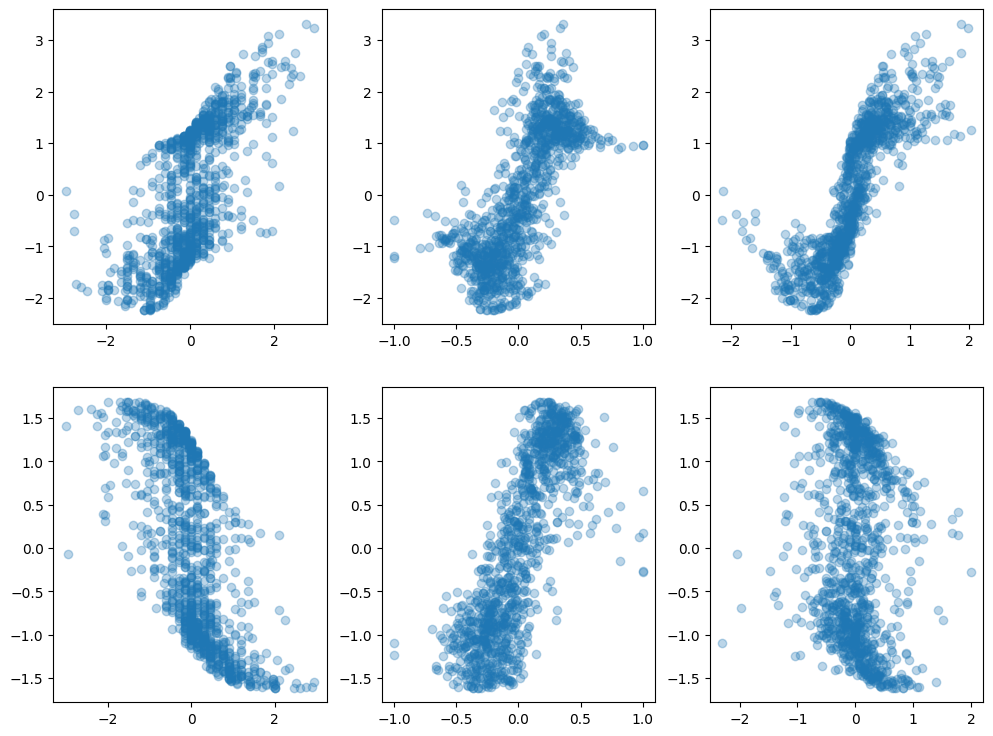

In [13]:
plt.figure(figsize=(12, 9))
plt.subplot(231)
plt.scatter(X_test[X_test[:, -1]==1, 0] - X_test[X_test[:, -1]==1, 1], 
            pred_v[X_test[:, -1]==1, 0] - pred_v[X_test[:, -1]==1, 1], alpha=0.3);

plt.subplot(232)
plt.scatter(X_test[X_test[:, -1]==1, 2] - X_test[X_test[:, -1]==1, 3], 
            pred_v[X_test[:, -1]==1, 0] - pred_v[X_test[:, -1]==1, 1], alpha=0.3);

plt.subplot(233)
plt.scatter(X_test[X_test[:, -1]==1, 0]*X_test[X_test[:, -1]==1, 2] - X_test[X_test[:, -1]==1, 1]*X_test[X_test[:, -1]==1, 3], 
            pred_v[X_test[:, -1]==1, 0] - pred_v[X_test[:, -1]==1, 1], alpha=0.3);

#####################
plt.subplot(234)
plt.scatter(X_test[X_test[:, -1]==-1, 0] - X_test[X_test[:, -1]==-1, 1], 
            pred_v[X_test[:, -1]==-1, 0] - pred_v[X_test[:, -1]==-1, 1], alpha=0.3);

plt.subplot(235)
plt.scatter(X_test[X_test[:, -1]==-1, 2] - X_test[X_test[:, -1]==-1, 3], 
            pred_v[X_test[:, -1]==-1, 0] - pred_v[X_test[:, -1]==-1, 1], alpha=0.3);

plt.subplot(236)
plt.scatter(X_test[X_test[:, -1]==-1, 0]*X_test[X_test[:, -1]==-1, 2] - X_test[X_test[:, -1]==-1, 1]*X_test[X_test[:, -1]==-1, 3], 
            pred_v[X_test[:, -1]==-1, 0] - pred_v[X_test[:, -1]==-1, 1], alpha=0.3);